PREDICCIÓN ESTADIO MELANOMA: COMPLETO

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


CARGAR LOS DATOS

In [17]:
df = pd.read_csv('df_truetarget.csv')
df.head()

,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,trueTarget
0,SKCM,SKCM,5564E6A7-2195-4B0D-994E-B0617B58E889,71.0,Male,STAGE IA,7TH,NaN,-26176,0.0,...,1.5289,-1.4791,-1.0775,-0.5874,0.7428,-0.2728,-2.0876,-2.2139,-0.1152,False
1,SKCM,SKCM,551E071A-C290-4B48-9000-F64C2A44DFB7,82.0,Male,STAGE IIA,6TH,2022.0,-30286,0.0,...,-0.5350,0.5245,0.2616,0.3533,-0.7334,-0.1408,-0.3072,-1.2198,0.6850,False
2,SKCM,SKCM,A29A20E3-5C2C-4F37-B93E-AE9EBC46EC53,82.0,Male,STAGE IIIA,7TH,NaN,-30163,0.0,...,-0.5780,-0.6422,-0.2198,0.6876,1.4183,0.2610,-0.4649,-0.5828,-0.0017,False
3,NaN,SKCM,3DD5A206-D7F3-42F1-B9CC-4B31C76D495D,46.0,Female,STAGE IIC,7TH,387.0,-17025,0.0,...,-0.0718,-0.1132,-0.1148,0.3637,-1.3046,-1.0278,0.2870,0.7965,-1.7373,True
4,NaN,SKCM,EFF78AF6-0F68-49B9-866B-0D511606F2B1,74.0,Female,STAGE IIC,7TH,14.0,-27124,0.0,...,0.4944,0.6672,0.3759,-0.7236,-1.3046,0.5597,0.2858,-0.6041,1.3473,True


PREPROCESAMIENTO DE LOS DATOS

In [18]:
df.shape

(436, 20549)

In [19]:
df['Diagnosis Age'] = df['Diagnosis Age'].fillna(df['Diagnosis Age'].mean())
df = df.dropna(axis=1)
df = df.dropna(axis=0)

In [20]:
df.shape

(436, 20177)

In [21]:
print(df.columns[:40])

Index(['TCGA PanCanAtlas Cancer Type Acronym', 'Other Patient ID',
       'Diagnosis Age', 'Sex', 'Birth from Initial Pathologic Diagnosis Date',
       'Form completion date',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',
       'Informed consent verified', 'Prior Diagnosis',
       'In PanCan Pathway Analysis', 'Overall Survival Status',
       'Progression Free Status', 'Genetic Ancestry Label', 'UBE2Q2P2',
       'HMGB1P1', 'RNU12-2P', 'SSX9P', 'EZHIP', 'EFCAB8', 'SRP14P1', 'TRIM75P',
       'SPATA31B1P', 'HSPB1P1', 'ANKRD20A20P', 'GTPBP6', 'EFCAB12', 'A1BG',
       'A1CF', 'A2BP1', 'A2LD1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAA1',
       'AAAS', 'AACS'],
      dtype='object')


In [30]:
exclude_columns = [
    'TCGA PanCanAtlas Cancer Type Acronym', 'Other Patient ID',
    'Birth from Initial Pathologic Diagnosis Date',
    'Form completion date', 'ICD-10 Classification',
    'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
    'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',
    'Informed consent verified',
    'Prior Diagnosis', 'In PanCan Pathway Analysis',
    'Progression Free Status',
]
clinicas_num = ['Diagnosis Age']
clinicas_cat = [
    'Sex', 
    'Neoadjuvant Therapy Type Administered Prior To Resection Text',
    'Genetic Ancestry Label'
]
genomic_columns = df.loc[:, 'SSX9P':'ZZZ3'].columns.tolist()

In [31]:
X = df.drop(columns=exclude_columns + ['trueTarget'])
y = df['trueTarget']

In [32]:
combined = pd.concat([X, y], axis=1)
combined = combined.dropna()
X = combined.drop(columns='trueTarget')
y = combined['trueTarget']

In [33]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)

ESCALADO, REDUCCIÓN DIMENSIONALIDAD Y CODIFICACIÓN

In [34]:
from sklearn.pipeline import Pipeline
genomic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=200))
])

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer([
    ('genomic', genomic_pipe, genomic_columns),
    ('num_clin', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), clinicas_num),
    ('cat_clin', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), clinicas_cat)
])

In [36]:
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

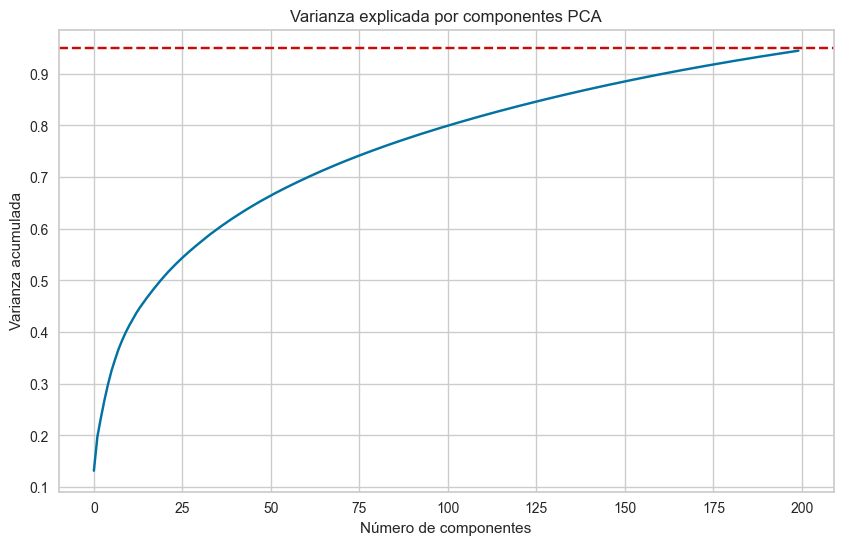

In [37]:
pca = preprocessor.named_transformers_['genomic'].named_steps['pca']

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Varianza explicada por componentes PCA')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.show()

In [38]:
pca = preprocessor.named_transformers_['genomic'].named_steps['pca']
n_pca_components = pca.n_components_
pca_columns = [f'PCA_{i+1}' for i in range(n_pca_components)]
num_clin_columns = clinicas_num
ohe = preprocessor.named_transformers_['cat_clin']
cat_clin_columns = ohe.get_feature_names_out(clinicas_cat)
all_columns = np.concatenate([pca_columns, num_clin_columns, cat_clin_columns])

X_train_df = pd.DataFrame(
    X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed,
    columns=all_columns,
    index=X_train.index
)
X_val_df = pd.DataFrame(
    X_val_processed.toarray() if hasattr(X_val_processed, 'toarray') else X_val_processed,
    columns=all_columns,
    index=X_val.index
)
X_test_df = pd.DataFrame(
    X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed,
    columns=all_columns,
    index=X_test.index
)

common_cols = list(set(X_train_df.columns) & set(X_val_df.columns) & set(X_test_df.columns))
X_train_df = X_train_df[common_cols]
X_val_df = X_val_df[common_cols]
X_test_df = X_test_df[common_cols]

print("NaNs en train:", X_train_df.isna().sum().sum())
print("NaNs en val:", X_val_df.isna().sum().sum())
print("NaNs en test:", X_test_df.isna().sum().sum())

train_df = X_train_df.copy()
train_df['trueTarget'] = y_train.values
val_df = X_val_df.copy()
val_df['trueTarget'] = y_val.values
test_df = X_test_df.copy()
test_df['trueTarget'] = y_test.values

NaNs en train: 0
NaNs en val: 0
NaNs en test: 0


MODELO CON PYCARET

In [39]:
clf = setup(
    data=train_df,
    target='trueTarget',
    session_id=42,
    test_data=test_df
)
best_model = compare_models()
print(best_model)

,Description,Value
0,Session id,42
1,Target,trueTarget
2,Target type,Binary
3,Original data shape,"(349, 210)"
4,Transformed data shape,"(349, 210)"
5,Transformed train set shape,"(261, 210)"
6,Transformed test set shape,"(88, 210)"
7,Numeric features,209
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.6285,0.0000,0.5797,0.6394,0.6012,0.2566,0.2603,0.0180
xgboost,Extreme Gradient Boosting,0.6245,0.6455,0.6495,0.6198,0.6317,0.2493,0.2529,0.2600
lr,Logistic Regression,0.6207,0.6940,0.5791,0.6387,0.6017,0.2408,0.2463,0.5590
knn,K Neighbors Classifier,0.6094,0.6088,0.5566,0.6330,0.5799,0.2182,0.2258,0.0420
rf,Random Forest Classifier,0.5980,0.5779,0.5588,0.6011,0.5757,0.1972,0.1972,0.1180
dt,Decision Tree Classifier,0.5823,0.5824,0.6187,0.5757,0.5913,0.1648,0.1680,0.0260
gbc,Gradient Boosting Classifier,0.5749,0.5761,0.5973,0.5714,0.5774,0.1510,0.1566,0.5860
lightgbm,Light Gradient Boosting Machine,0.5741,0.6052,0.6176,0.5729,0.5902,0.1482,0.1509,0.0930
ada,Ada Boost Classifier,0.5711,0.5614,0.5962,0.5768,0.5804,0.1423,0.1440,0.1560
ridge,Ridge Classifier,0.5670,0.0000,0.5643,0.5727,0.5620,0.1336,0.1373,0.0150


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


TUNEAMOS EL MODELO

In [40]:
XGBoost = create_model('xgboost')
tuned_xgb = tune_model(XGBoost, optimize='f1')
evaluate_model(tuned_xgb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6296,0.7802,0.5714,0.6667,0.6154,0.2623,0.2652
1,0.6923,0.7219,0.6923,0.6923,0.6923,0.3846,0.3846
2,0.6538,0.5976,0.6923,0.6429,0.6667,0.3077,0.3086
3,0.5769,0.5799,0.5385,0.5833,0.5600,0.1538,0.1543
4,0.6538,0.6272,0.6923,0.6429,0.6667,0.3077,0.3086
5,0.6923,0.6864,0.7692,0.6667,0.7143,0.3846,0.3892
6,0.6538,0.7041,0.8462,0.6111,0.7097,0.3077,0.3333
7,0.5385,0.5917,0.5385,0.5385,0.5385,0.0769,0.0769
8,0.6154,0.6627,0.6154,0.6154,0.6154,0.2308,0.2308


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4815,0.5055,0.8571,0.5000,0.6316,-0.0678,-0.1048
1,0.5769,0.7160,0.9231,0.5455,0.6857,0.1538,0.2132
2,0.5385,0.5799,1.0000,0.5200,0.6842,0.0769,0.2000
3,0.5385,0.5917,0.9231,0.5217,0.6667,0.0769,0.1204
4,0.5385,0.6805,0.9231,0.5217,0.6667,0.0769,0.1204
5,0.6154,0.6746,1.0000,0.5652,0.7222,0.2308,0.3612
6,0.5000,0.5089,1.0000,0.5000,0.6667,0.0000,0.0000
7,0.5769,0.5976,1.0000,0.5417,0.7027,0.1538,0.2887
8,0.6154,0.5680,0.8462,0.5789,0.6875,0.2308,0.2601


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

VISUALIZACIÓN PRIMER TUNEO

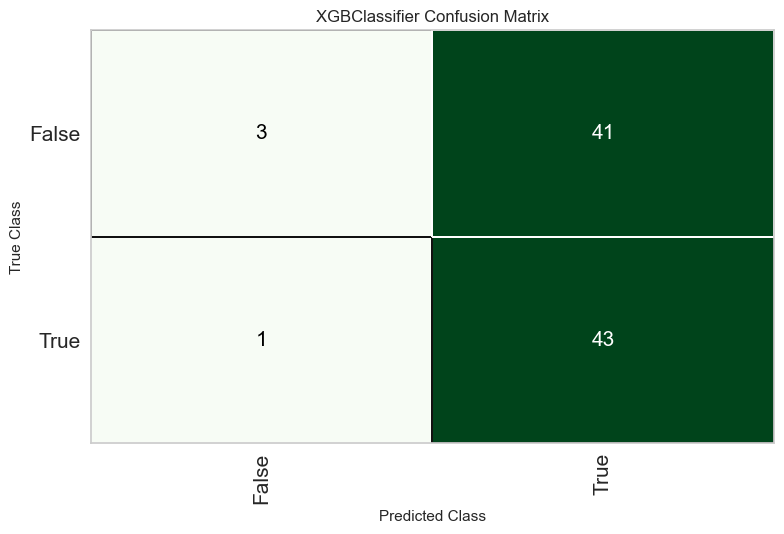

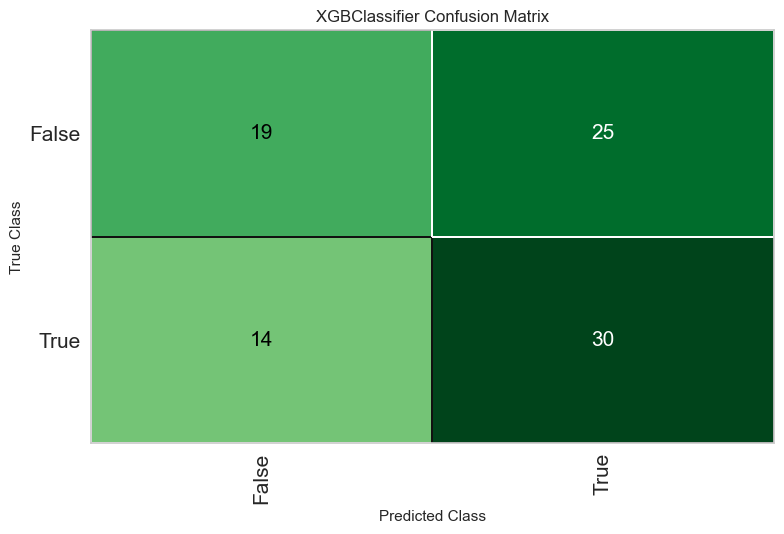

In [48]:
from pycaret.classification import plot_model

plot_model(tuned_xgb, plot='confusion_matrix')
plot_model(XGBoost, plot='confusion_matrix')

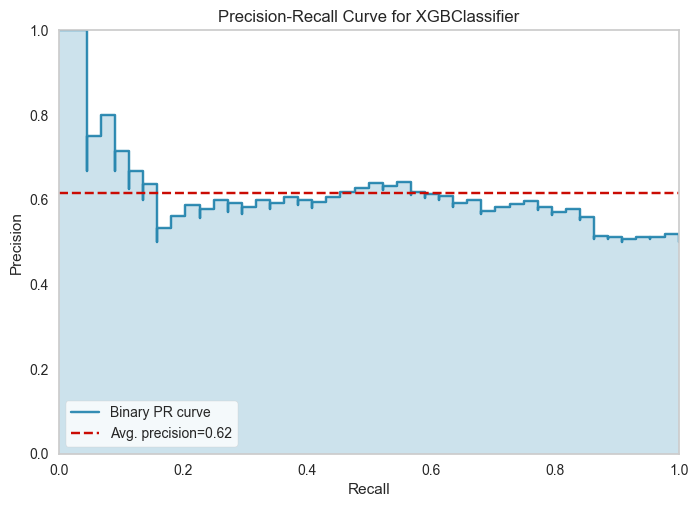

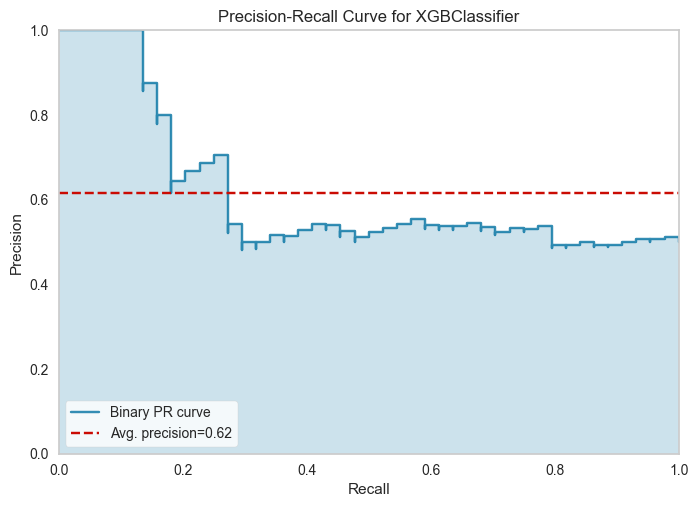

In [49]:
plot_model(tuned_xgb, plot='pr')
plot_model(XGBoost, plot='pr')

DISTRIBUCIÓN BAYESIANA

In [43]:
from pycaret.classification import predict_model
resultados_test = predict_model(tuned_xgb, data=test_df)
resultados_test.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5227,0.6214,0.9773,0.5119,0.6719,0.0455,0.1091


,PCA_115,PCA_92,PCA_6,PCA_40,PCA_36,PCA_3,PCA_190,PCA_111,PCA_81,PCA_170,...,PCA_181,PCA_165,PCA_148,PCA_189,PCA_43,PCA_153,PCA_9,trueTarget,prediction_label,prediction_score
290,-0.882981,2.520992,-8.449059,3.053701,-2.738054,6.900713,-0.964888,-4.371374,1.273348,2.542953,...,-6.605788,2.744913,1.484173,0.868544,-0.737615,0.104926,-26.961185,True,1,0.9886
148,-2.931181,2.888510,-4.271588,4.580153,-2.629951,-2.015091,-0.091624,-4.234028,-0.421320,3.034409,...,-2.601685,-0.255544,1.212706,5.059302,4.533550,-0.307939,-3.950863,False,1,0.9231
386,3.457767,-0.735870,2.080132,-2.416065,4.832904,36.691612,1.660272,0.903027,-0.684502,0.226088,...,0.545839,-0.080542,-0.367819,-0.577979,3.035511,0.414928,33.424076,False,1,0.8575
342,0.413521,2.148326,-33.817638,7.738011,-3.932611,-7.350615,-1.663370,-0.845370,-2.153475,-0.496847,...,-0.446888,-2.558274,1.335831,-0.351164,4.952487,0.362733,46.407673,True,1,0.9543
274,-1.975764,-0.477417,12.255246,1.217094,6.173615,-17.981083,0.330999,0.726983,0.662903,1.970853,...,-1.407811,0.014888,0.988944,-0.539014,5.022643,1.648348,7.078777,False,1,0.9871


In [91]:
y_test_clean = y_test.map({False: 0, True: 1}).dropna()
y_probas = XGBoost.predict_proba(X_test_processed)[:, 1]
df_bayesian = pd.DataFrame({
    'Score': y_probas,
    'Clase': y_test_clean.reset_index(drop=True).map({1: 'Agresivo', 0: 'No Agresivo'})
})

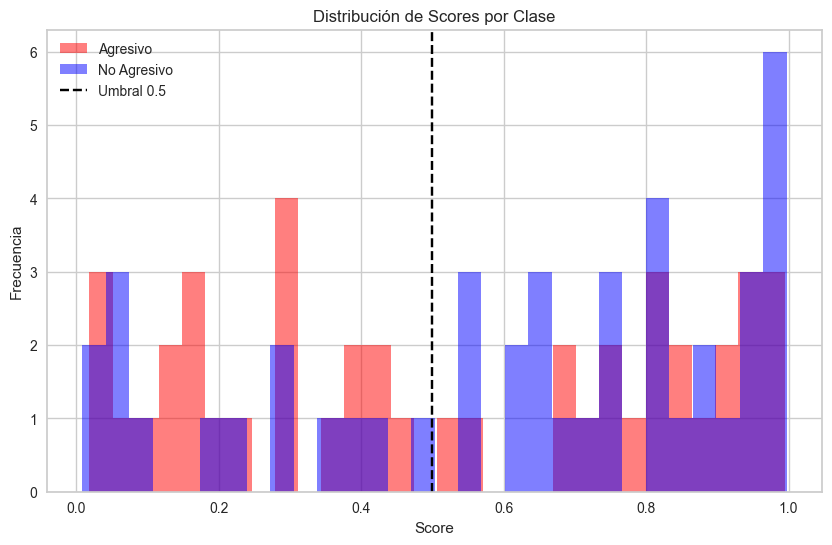

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(df_bayesian[df_bayesian['Clase'] == 'Agresivo']['Score'], bins=30, alpha=0.5, label='Agresivo', color='red')
plt.hist(df_bayesian[df_bayesian['Clase'] == 'No Agresivo']['Score'], bins=30, alpha=0.5, label='No Agresivo', color='blue')
plt.axvline(0.5, color='black', linestyle='--', label='Umbral 0.5')
plt.title('Distribución de Scores por Clase')
plt.xlabel('Score')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

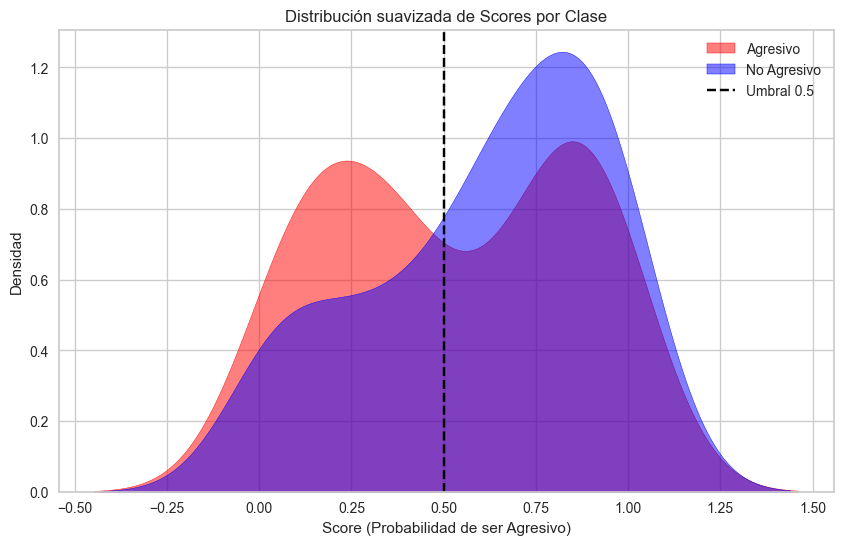

In [70]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_bayesian[df_bayesian['Clase'] == 'Agresivo']['Score'], label='Agresivo', fill=True, color='red', alpha=0.5)
sns.kdeplot(df_bayesian[df_bayesian['Clase'] == 'No Agresivo']['Score'], label='No Agresivo', fill=True, color='blue', alpha=0.5)
plt.axvline(0.5, color='black', linestyle='--', label='Umbral 0.5')
plt.title('Distribución suavizada de Scores por Clase')
plt.xlabel('Score (Probabilidad de ser Agresivo)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

OPTUNA PARA OPTIMIZAR HIPERPARÁMETROS

In [52]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='f1').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Mejores parámetros:", study.best_params)
print("Mejor f1-score:", study.best_value)



[I 2025-07-23 13:07:28,633] A new study created in memory with name: no-name-5da949d8-2a4a-465c-ad0f-d84a9054dc6b
[I 2025-07-23 13:07:34,683] Trial 0 finished with value: 0.6197207107130562 and parameters: {'n_estimators': 146, 'max_depth': 6, 'learning_rate': 0.005482531261036065, 'subsample': 0.6909666117979508, 'colsample_bytree': 0.8217666153641244, 'gamma': 0.5475292554649935, 'reg_alpha': 0.10760041306294021, 'reg_lambda': 0.5429197543925393}. Best is trial 0 with value: 0.6197207107130562.
[I 2025-07-23 13:07:42,701] Trial 1 finished with value: 0.611999075459533 and parameters: {'n_estimators': 245, 'max_depth': 6, 'learning_rate': 0.01398491627134162, 'subsample': 0.9325181271896132, 'colsample_bytree': 0.854029975555406, 'gamma': 1.3521174410390446, 'reg_alpha': 0.43763493880303095, 'reg_lambda': 0.3634623789661373}. Best is trial 0 with value: 0.6197207107130562.
[I 2025-07-23 13:07:45,817] Trial 2 finished with value: 0.5993574709779643 and parameters: {'n_estimators': 299,

Mejores parámetros: {'n_estimators': 76, 'max_depth': 10, 'learning_rate': 0.0017430923348864692, 'subsample': 0.8322728566198092, 'colsample_bytree': 0.9136836954057179, 'gamma': 3.6623386270825167, 'reg_alpha': 0.8232522053870537, 'reg_lambda': 0.8494754112470719}
Mejor f1-score: 0.692295604332055


In [53]:
best_params = study.best_params
best_model_optuna = XGBClassifier(**best_params, random_state=42)
best_model_optuna.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9136836954057179, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.6623386270825167,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0017430923348864692,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=76, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [54]:
y_pred_optuna = best_model_optuna.predict(X_test_processed)
y_pred_proba_optuna = best_model_optuna.predict_proba(X_test_processed)[:, 1]
print(best_model_optuna.score(X_test_processed, y_test))
final_f1 = f1_score(y_test, y_pred_optuna)
final_f1

0.5568181818181818


0.6285714285714287

VISUALIZACIÓN RESULTADOS OPTUNA

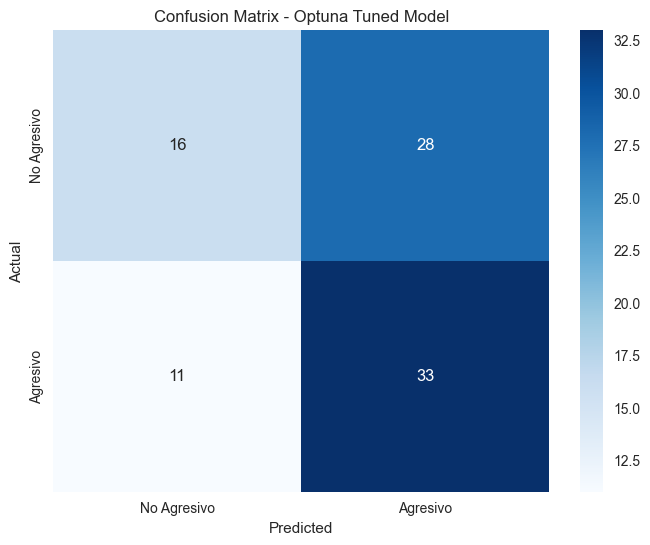

In [55]:
cm = confusion_matrix(y_test, y_pred_optuna)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Agresivo', 'Agresivo'], yticklabels=['No Agresivo', 'Agresivo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optuna Tuned Model')
plt.show()

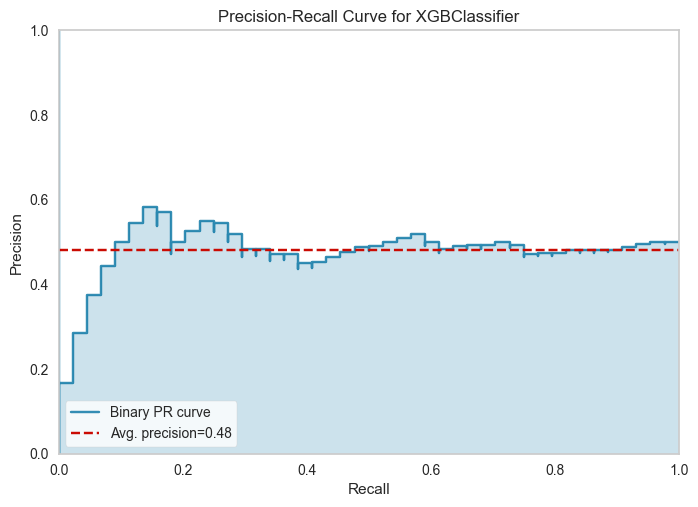

In [61]:
plot_model(best_model_optuna, plot='pr')

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_optuna))

              precision    recall  f1-score   support

       False       0.59      0.36      0.45        44
        True       0.54      0.75      0.63        44

    accuracy                           0.56        88
   macro avg       0.57      0.56      0.54        88
weighted avg       0.57      0.56      0.54        88



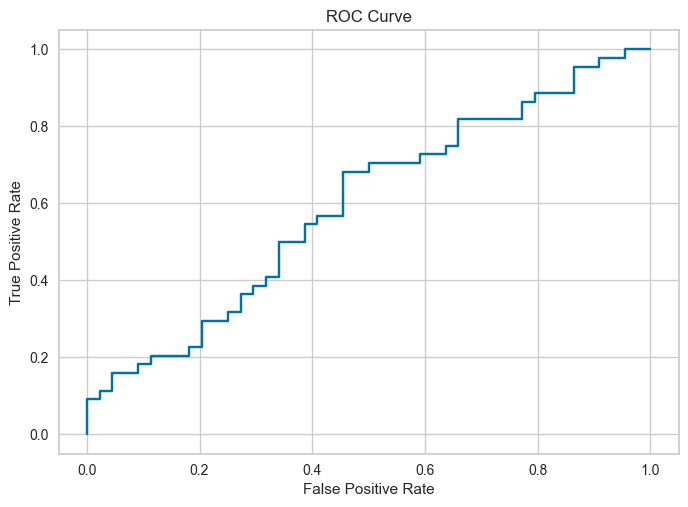

In [59]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optuna)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

CAMBIO UMBRALES OPTUNA

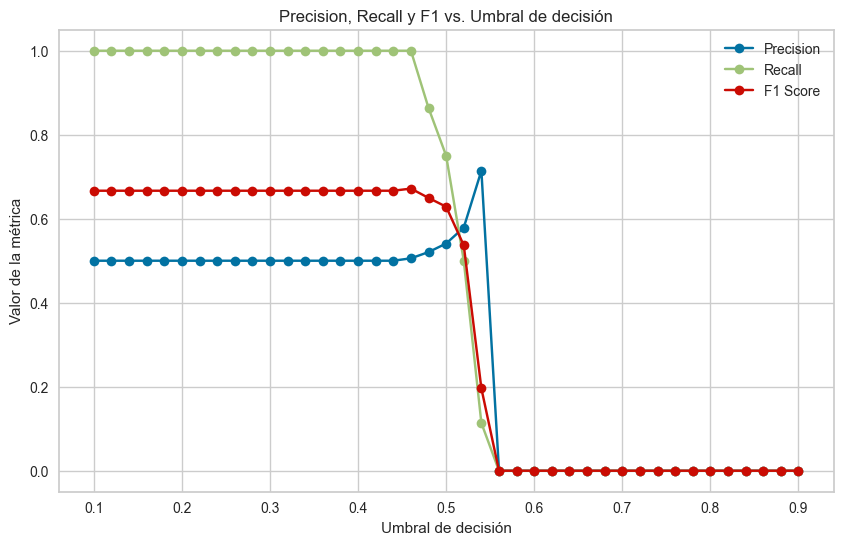

In [72]:
thresholds = np.arange(0.1, 0.91, 0.02) #distintos umbrales de decisión
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred = (y_pred_proba_optuna >= thresh).astype(int) #comparo probabilidades con el umbral, mayor probabilidad es agrisivo, menor es no agresivo
    precisions.append(precision_score(y_test, y_pred)) #precisión de las positivas (nº de correctas)
    recalls.append(recall_score(y_test, y_pred)) #recall de las positivas (cuantos positivos he detectado)
    f1s.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.xlabel('Umbral de decisión')
plt.ylabel('Valor de la métrica')
plt.title('Precision, Recall y F1 vs. Umbral de decisión')
plt.legend()
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

       False       0.59      0.36      0.45        44
        True       0.54      0.75      0.63        44

    accuracy                           0.56        88
   macro avg       0.57      0.56      0.54        88
weighted avg       0.57      0.56      0.54        88



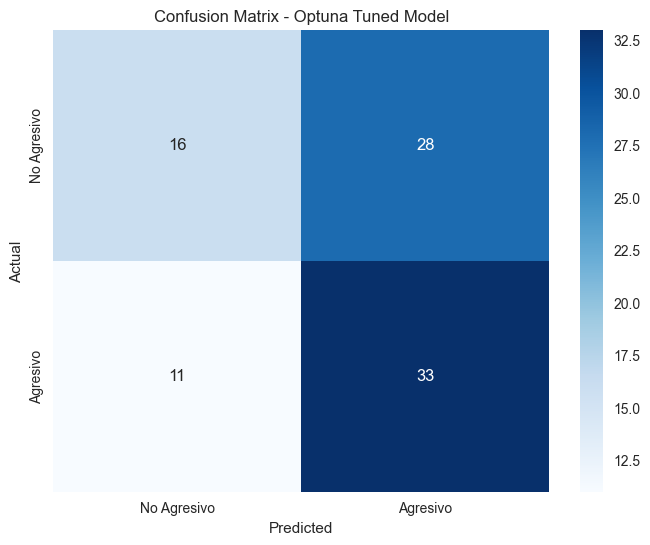

In [84]:
umbral = 0.5
y_pred_46 = (y_pred_proba_optuna >= umbral).astype(int)
print(classification_report(y_test, y_pred_46))
cm = confusion_matrix(y_test, y_pred_46)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Agresivo', 'Agresivo'], yticklabels=['No Agresivo', 'Agresivo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optuna Tuned Model')
plt.show()

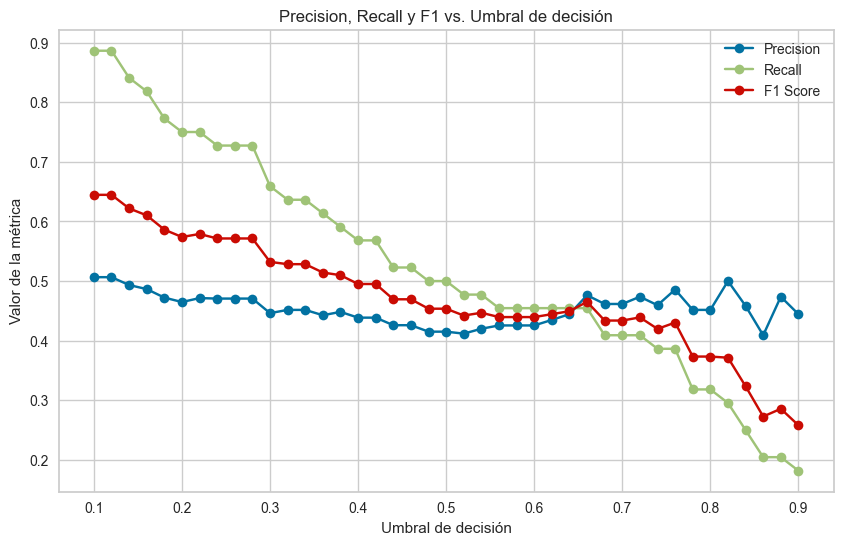

In [ ]:
thresholds = np.arange(0.1, 0.91, 0.02) #distintos umbrales de decisión
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred = (y_probas >= thresh).astype(int) #comparo probabilidades con el umbral, mayor probabilidad es agrisivo, menor es no agresivo
    precisions.append(precision_score(y_test, y_pred)) #precisión de las positivas (nº de correctas)
    recalls.append(recall_score(y_test, y_pred)) #recall de las positivas (cuantos positivos he detectado)
    f1s.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.xlabel('Umbral de decisión')
plt.ylabel('Valor de la métrica')
plt.title('Precision, Recall y F1 vs. Umbral de decisión')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

       False       0.39      0.27      0.32        44
        True       0.44      0.57      0.50        44

    accuracy                           0.42        88
   macro avg       0.41      0.42      0.41        88
weighted avg       0.41      0.42      0.41        88



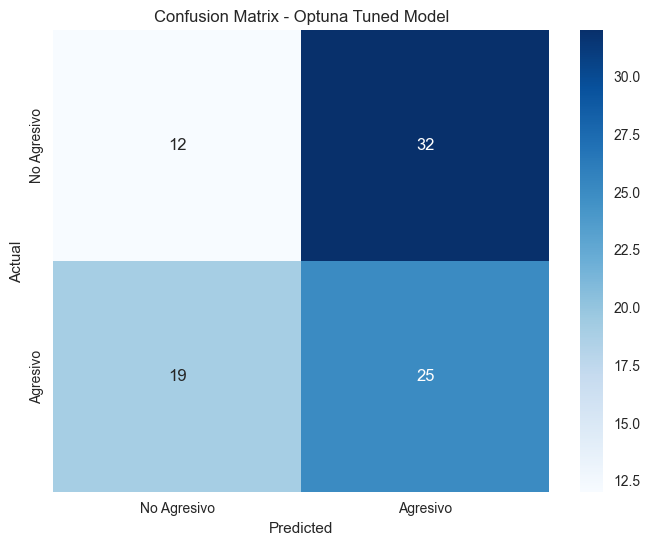

In [93]:
umbral = 0.4
y_pred_46 = (y_probas >= umbral).astype(int)
print(classification_report(y_test, y_pred_46))
cm = confusion_matrix(y_test, y_pred_46)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Agresivo', 'Agresivo'], yticklabels=['No Agresivo', 'Agresivo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optuna Tuned Model')
plt.show()

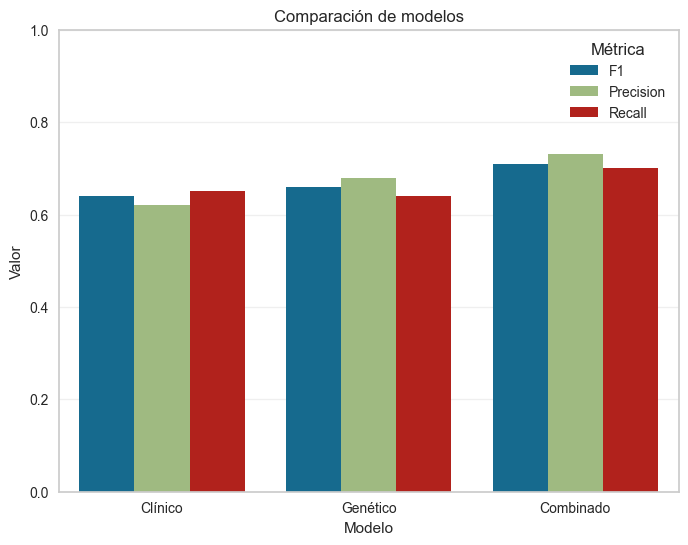

In [94]:
df_comparativa = pd.DataFrame({
    'Modelo': ['Clínico', 'Genético', 'Combinado'],
    'F1': [0.64, 0.66, 0.71],
    'Precision': [0.62, 0.68, 0.73],
    'Recall': [0.65, 0.64, 0.70]
})

df_melted = df_comparativa.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(8,6))
sns.barplot(data=df_melted, x='Modelo', y='Valor', hue='Métrica')
plt.title('Comparación de modelos')
plt.ylim(0, 1)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

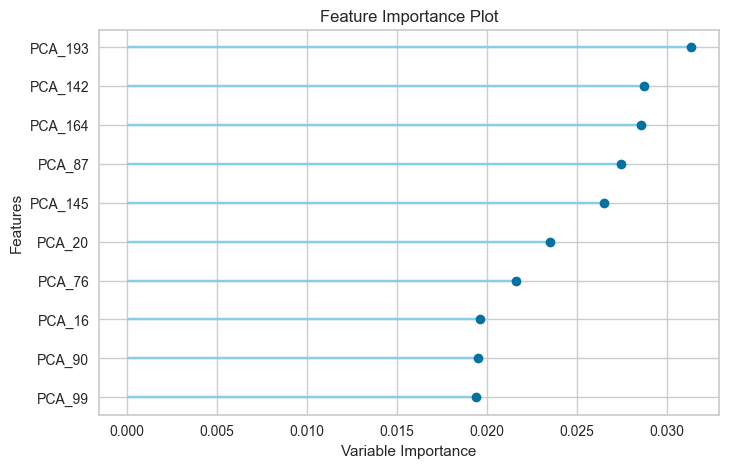

In [95]:
plot_model(XGBoost, plot='feature')